# Bagging

In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from sklearn.datasets import load_breast_cancer
dataset=load_breast_cancer()
X=dataset.data
Y=dataset.target

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.30,random_state=355)

In [4]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,Y_train)
knn.score(X_test,Y_test)

0.9181286549707602

In [5]:
bag_knn=BaggingClassifier(KNeighborsClassifier(n_neighbors=5),n_estimators=10,
                          max_samples=0.5,random_state=3489,
                          bootstrap=True,oob_score=True)
bag_knn.fit(X_train,Y_train)
bag_knn.score(X_test,Y_test)

0.9298245614035088

### Pasting 

Without Bootstrap

In [6]:
pasting=BaggingClassifier(KNeighborsClassifier(n_neighbors=5),
                          n_estimators=10,max_samples=0.5,
                          random_state=3489,bootstrap=False)
pasting.fit(X_train,Y_train)
pasting.score(X_test,Y_test)

0.9181286549707602

# Random Forest

## Problem Statement

To build an application to classify the patients to be haelthy or suffering from cardiovascular disease based on the given attributes.

In [7]:
#Important libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocessing,Normalizing
from sklearn.preprocessing import StandardScaler

#Multi-Collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Models
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#metrices
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [8]:
data=pd.read_csv("https://raw.githubusercontent.com/training-ml/Files/main/cardio_train.csv",sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [9]:
data.shape

(69301, 13)

In [10]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,50471.480397,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,28563.100347,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,988.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25745.000000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50494.000000,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,75150.000000,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Observations

In [11]:
#No mising values
#Outliers in height & weight features
#Ouliers in ap_hi & ap_lo too.
#gluc & chlostrol are categorical

### Remove duplicates

In [12]:
data=data.drop('id',axis=1)
data=data.drop_duplicates()

In [13]:
data.shape

(69277, 12)

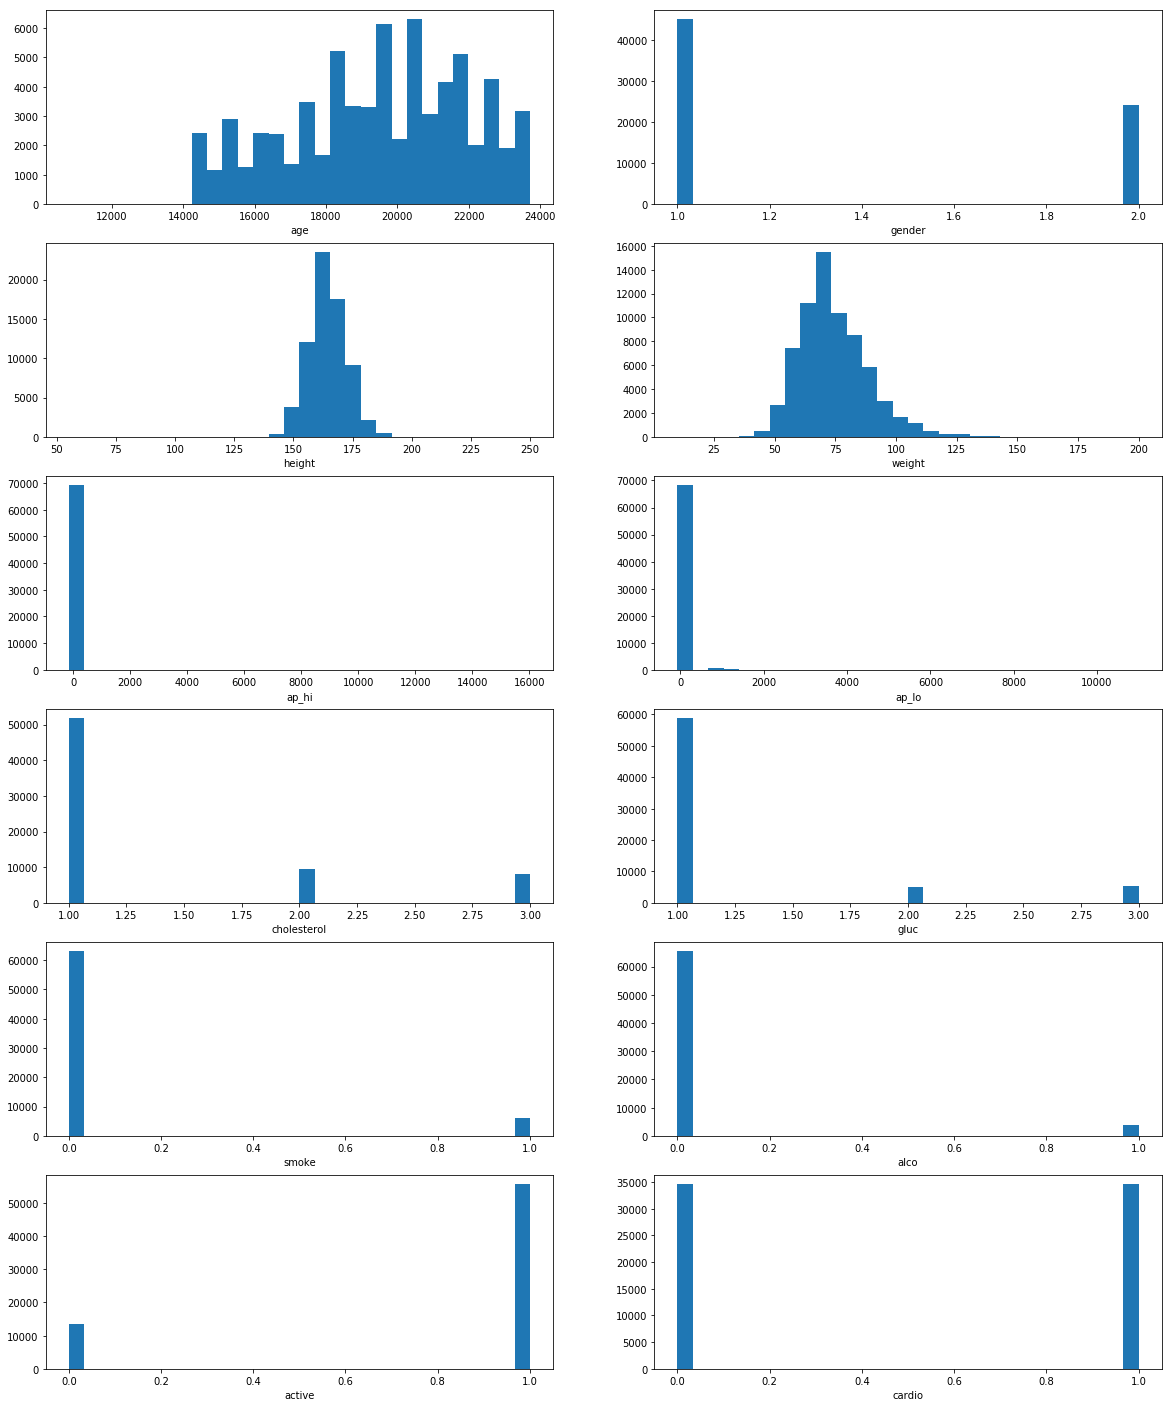

In [14]:
plt.figure(figsize=(20,25),facecolor='W')
grp=1
for col in data:
    if grp<=12:
        ax=plt.subplot(6,2,grp)
        plt.hist(data[col],bins=30)
        plt.xlabel(col)
    grp+=1
plt.show()

In [15]:
#with std 3 see the stats

#Zscore=(X-mean)/std

from scipy.stats import zscore
zscore=zscore(data[['age','height','weight','ap_hi','ap_lo']])
abs_Zscore=np.abs(zscore)
filtered=(abs_Zscore<3).all(axis=1)
data=data[filtered]
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000
mean,19466.779053,1.347268,164.374555,73.566278,126.164430,81.286001,1.362010,1.223575,0.087159,0.053281,0.803949,0.492815
std,2467.040240,0.476105,7.690310,13.195627,17.860035,10.236086,0.677075,0.569505,0.282069,0.224595,0.397011,0.499952
min,14275.000000,1.000000,140.000000,32.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17660.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19702.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21324.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,188.000000,117.000000,401.000000,602.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


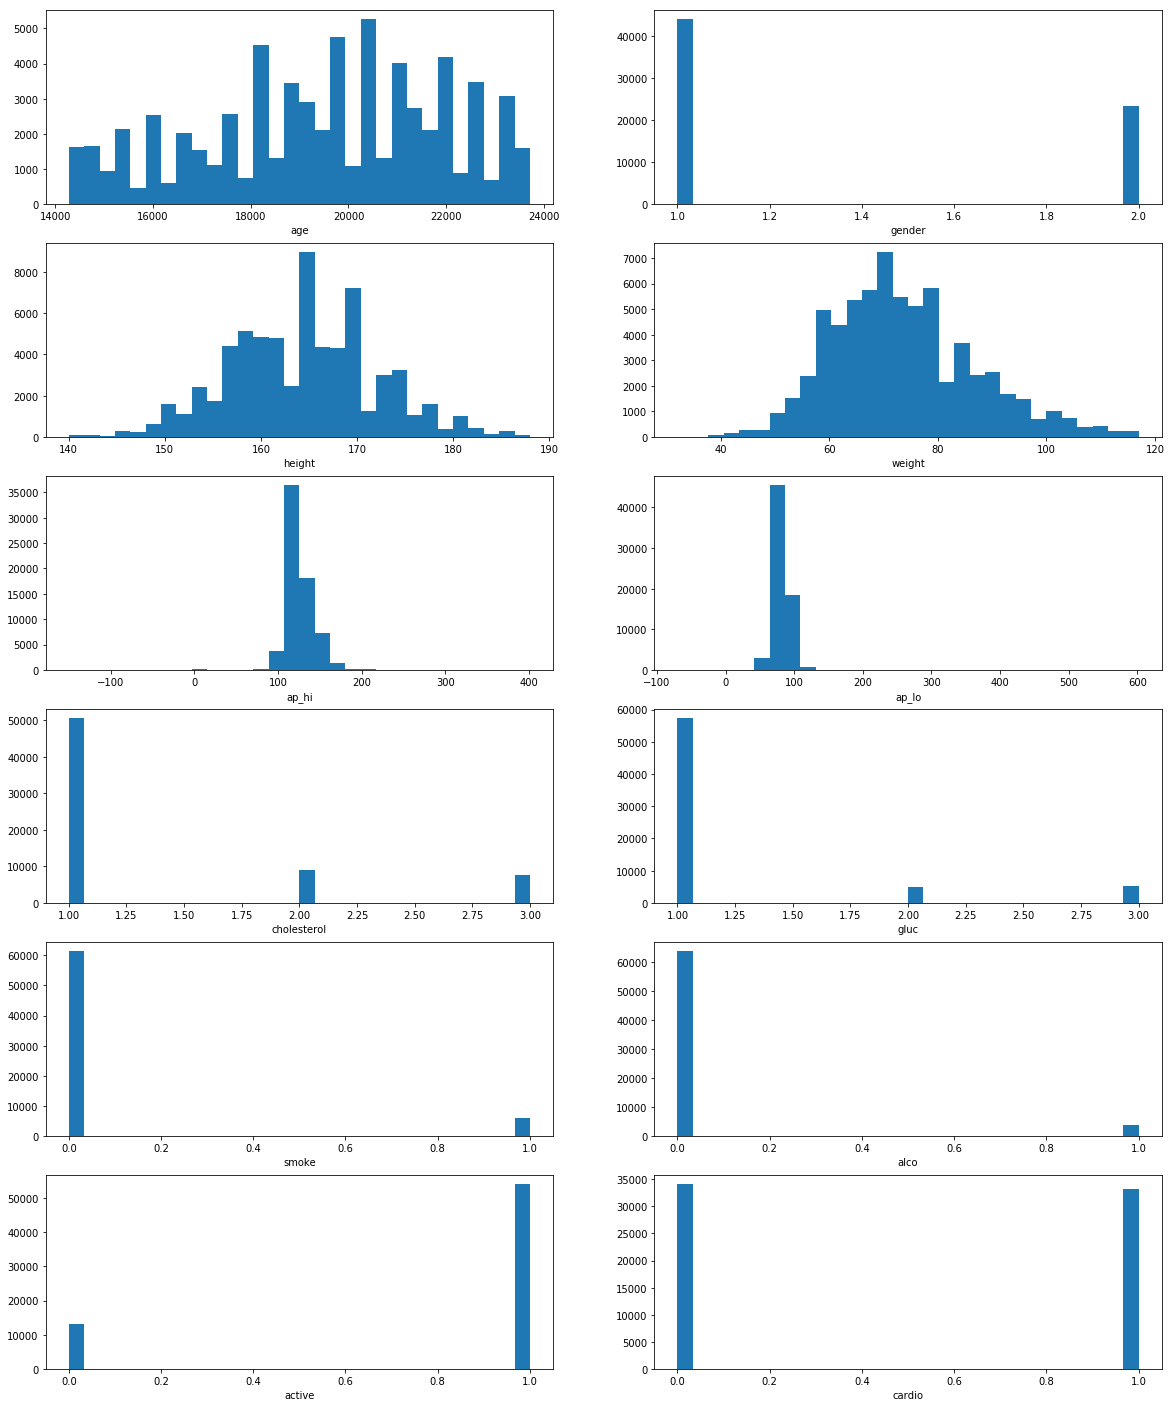

In [16]:
plt.figure(figsize=(20,25),facecolor='W')
grp=1
for col in data:
    if grp<=12:
        ax=plt.subplot(6,2,grp)
        plt.hist(data[col],bins=30)
        plt.xlabel(col)
    grp+=1
plt.show()

In [17]:
X=data.drop('cardio',axis=1)
Y=data['cardio']

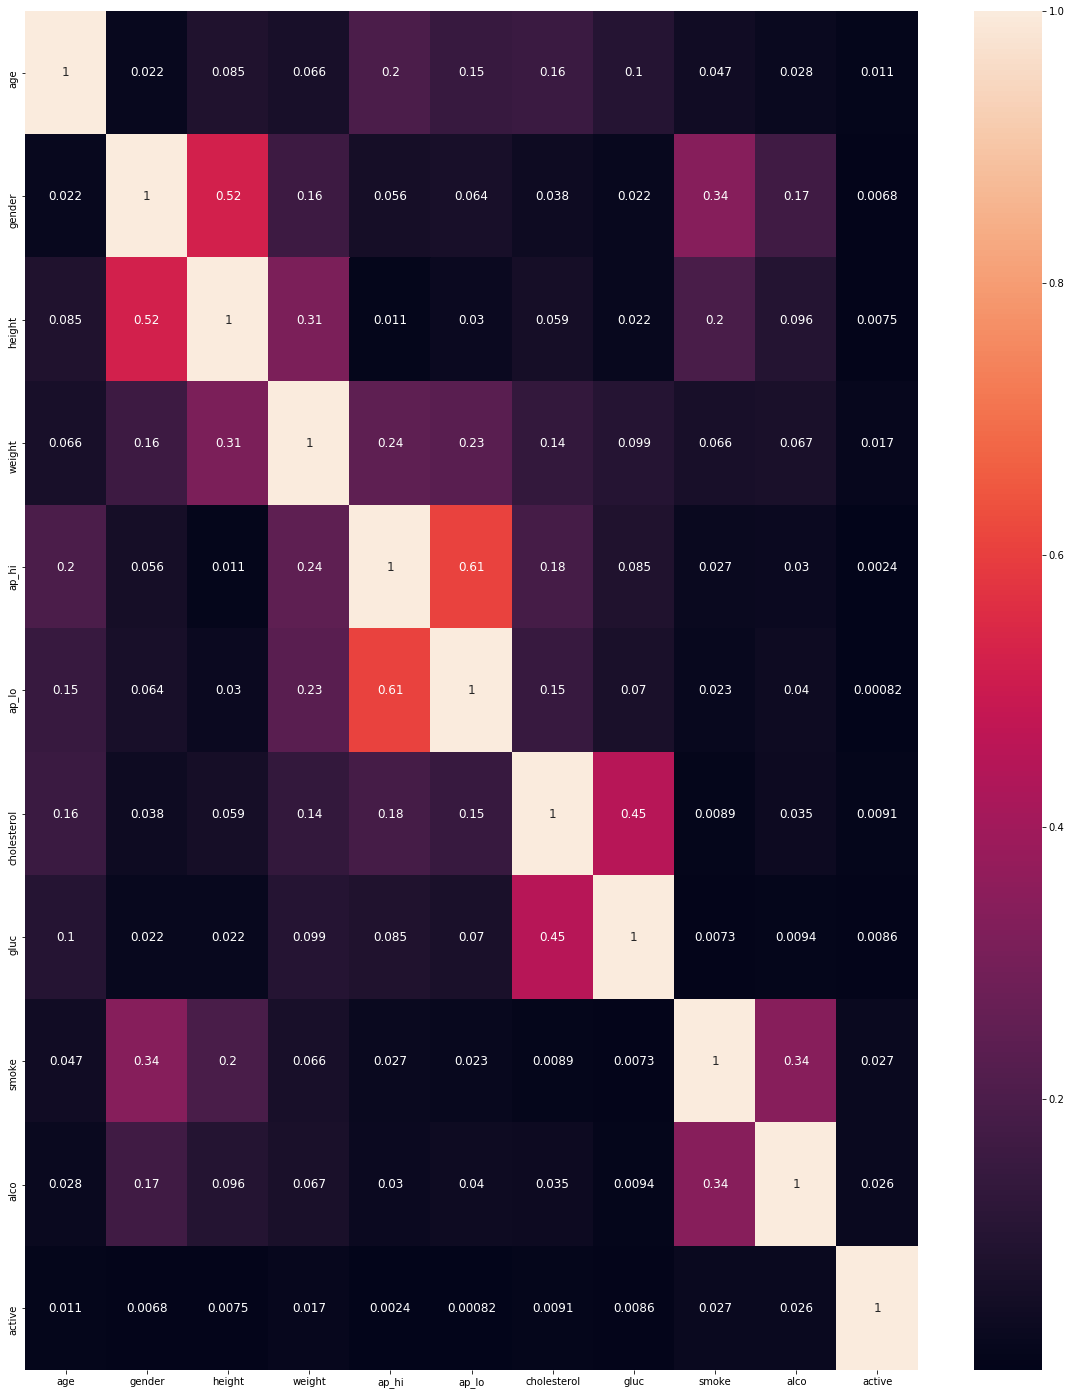

In [18]:
plt.figure(figsize=(20,25))
Xcorr=X.corr().abs()
sns.heatmap(Xcorr,annot=True,annot_kws={'size':12})
plt.show()


### HyperParameter Tuning

In [38]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=355)

clf=RandomForestClassifier()

param={
    'n_estimators':[21,23],
    'criterion':['entropy','gini'],
    'min_samples_split':[9,11],
    'max_depth':[8,10],
    'min_samples_leaf':[5,6]
}
grd=GridSearchCV(clf,param_grid=param)
grd.fit(X_train,Y_train)
print("Best Pramaeters:",grd.best_params_)

clf=grd.best_estimator_   #reinstantiating the beast parameter to algo

clf.fit(X_train,Y_train)
ypred=clf.predict(X_test)

print("Confusion Matrix::\n",confusion_matrix(Y_test,ypred))

print("Accuracy::",accuracy_score(Y_test,ypred))

print("Classification Report::\n",classification_report(Y_test,ypred))

Best Pramaeters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 23}
Confusion Matrix::
 [[7890 2287]
 [3128 6903]]
Accuracy:: 0.7320368171021377
Classification Report::
               precision    recall  f1-score   support

           0       0.72      0.78      0.74     10177
           1       0.75      0.69      0.72     10031

    accuracy                           0.73     20208
   macro avg       0.73      0.73      0.73     20208
weighted avg       0.73      0.73      0.73     20208



### Plot ROC AUC Curve

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve,plot_roc_curve

In [41]:
lr=LogisticRegression()
knn=KNeighborsClassifier()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()

In [43]:
lr.fit(X_train,Y_train)
knn.fit(X_train,Y_train)
dt.fit(X_train,Y_train)
rf.fit(X_train,Y_train)
print("All models are trained!!")

All models are trained!!


In [44]:
lr.score(X_test,Y_test)
knn.score(X_test,Y_test)
dt.score(X_test,Y_test)
rf.score(X_test,Y_test)
print("All models test scored are captured!!")

All models test scored are captured!!


### Checking Roc plotted Curve

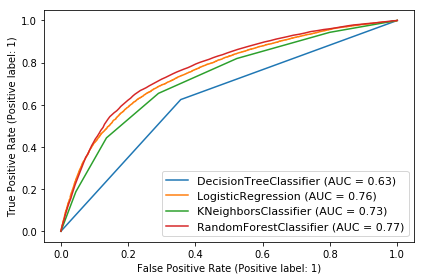

In [46]:
dis=plot_roc_curve(dt,X_test,Y_test)
plot_roc_curve(lr,X_test,Y_test,ax=dis.ax_)
plot_roc_curve(knn,X_test,Y_test,ax=dis.ax_)
plot_roc_curve(rf,X_test,Y_test,ax=dis.ax_)
plt.legend(prop={'size':11},loc='lower right')
plt.tight_layout()